# Infer ***lipid droplet*** - part 7️⃣

--------------

## OBJECTIVE 
### <input type="checkbox"/> Infer sub-cellular component ***lipid droplets***
Segment the ***lipid droplets*** from a single channel (neutrolipid dye). This workflow was optimized for images of the fluorescently dye BODIPY. 

---------------------
## infer ***LD*** 
### summary of steps 

➡️ **EXTRACTION**
- **`STEP 1`** - Select a channel for segmentation

  - select single channel containing the lipid droplet marker (channel number = user input)

**PRE-PROCESSING**
- **`STEP 2`** - Rescale and smooth image

  - rescale intensity of composite image (min=0, max=1)
  - median filter (median size = user input)
  - gaussian filter (sigma = user input)

**CORE PROCESSING**
- **`STEP 3`** - Apply basic threshold

  - apply threshold of the user's choice (`otsu`, `li`, `triangle`, `median` or `ave_tri_med`) (thresholding method, thresholding options = user input)

**POST-PROCESSING**
- **`STEP 4`** - Remove small holes and objects

  - fill holes (hole size = user input)
  - remove small objects (object size = user input)
  - filter method (method = user input)

**POST-POST-PROCESSING**
- **`STEP 5`** - Label objects

  - label unique lipid droplet objects based on connectivity

**EXPORT** ➡️
- save labeled ***lipid droplet*** (LD) as unsigned integer 16-bit tif files

---------------------
## **IMPORTS**

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block loads all of the necessary python packages and functions you will need for this notebook.

In [ ]:
from pathlib import Path
import os

import numpy as np
import napari
from napari.utils.notebook_display import nbscreenshot

from infer_subc.core.file_io import (read_czi_image,
                                     export_inferred_organelle,
                                     list_image_files,
                                     sample_input)

from infer_subc.core.img import *

%load_ext autoreload
%autoreload 2

## **LOAD AND READ IN IMAGE FOR PROCESSING**

#### &#x1F6D1; &#x270D; **User Input Required:**

In [ ]:
### USER INPUT REQUIRED ###
# If using the sample data, select which cell type you would like analyze ("neuron" or "astrocyte"):
# If not using the sample data, set cell_type to None
sample_data_type = "neuron"

# Specify which file you'd like to segment from the img_file_list
test_img_n = 0

# If you are not using the sample data, please edit "USER SPECIFIED" as necessary.
## Define the path to the directory that contains the input image folder.
data_root_path = Path("USER SPECIFIED")

# Specify the file type of your raw data that will be analyzed. Ex) ".czi" or ".tiff"
im_type = "USER SPECIFIED"

## Specify which subfolder that contains the input data and the input data file extension
in_data_path = data_root_path / "USER SPECIFIED"

## Specify the output folder to save the segmentation outputs if.
## If its not already created, the code below will creat it for you
out_data_path = data_root_path / "USER SPECIFIED"

#### &#x1F3C3; **Run code; no user input required**

In [ ]:
# If sample_data_type is set to "neuron" or "astrocyte", then the sample data is used and the directories are set
if sample_data_type != None:
    data_root_path, im_type, in_data_path, out_data_path = sample_input(sample_data_type)

In [3]:
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

img_file_list = list_image_files(in_data_path,im_type)
# pd.set_option('display.max_colwidth', None)
# pd.DataFrame({"Image Name":img_file_list})

In [4]:
test_img_name = img_file_list[test_img_n]

img_data,meta_dict = read_czi_image(test_img_name)

channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

# ***EXTRACTION prototype - LD***

## **`STEP 1` - Select a channel for segmentation**

- select single channel containing the lipid droplet marker (channel number = user input)

In [5]:
###################
# INPUT
###################
LD_CH = 0
raw_LD = select_channel_from_raw(img_data, LD_CH)

# ***PRE-PROCESSING prototype - LD***

## **`STEP 2` - Rescale and smooth image**

- rescale intensity of composite image (min=0, max=1)
- median filter (median size = user input)
- gaussian filter (sigma = user input)

In [6]:
###################
# PRE_PROCESSING
###################
median_sz = 0
gauss_sig = 0

struct_img =  scale_and_smooth(raw_LD,
                               median_size = median_sz, 
                               gauss_sigma = gauss_sig)


# ***CORE-PROCESSING prototype - LD***

## **`STEP 3` -  Apply basic threshold**

- apply threshold of the user's choice (`otsu`, `li`, `triangle`, `median` or `ave_tri_med`) (thresholding method, thresholding options = user input)

In [7]:
###################
# CORE_PROCESSING
###################
method = "otsu"
threshold_factor = 1
thresh_min = 0.120
thresh_max = 1
otsu_thresholded = apply_threshold(struct_img, 
                                   method= method, 
                                   thresh_factor=threshold_factor, 
                                   thresh_min=thresh_min, 
                                   thresh_max=thresh_max)

# ***POST-PROCESSING prototype - LD***

## **`STEP 4` - Remove small holes and objects**

- fill holes (hole size = user input)
- remove small objects (object size = user input)
- filter method (method = user input)

In [8]:
###################
# POST_PROCESSING
###################
hole_min_width = 0
hole_max_width = 0

small_object_width = 1

fill_filter_method = "3D"

cleaned_img2 = fill_and_filter_linear_size(otsu_thresholded, 
                                           hole_min=hole_min_width, 
                                           hole_max=hole_max_width, 
                                           min_size=small_object_width,
                                           method=fill_filter_method)

# ***POST-POST-PROCESSING prototype - LD***

## **`STEP 5` - Label objects**

- label unique lipid droplet objects based on connectivity

In [9]:
###################
# LABELING
###################
LD_labels = label_uint16(cleaned_img2)

In [10]:
LD_labels.dtype

dtype('uint16')

## **Visualize with `napari` 1**
Visualize the first-pass segmentation and labeling with `napari`.

In [32]:
viewer = napari.Viewer(title = "lipid droplet",
                       ndisplay=3)

In [33]:
viewer.add_image(
    struct_img,
    scale = scale,
    opacity=0.3,
    name = "LD Intensities")    

viewer.add_image(
    cleaned_img2,
    scale = scale,
    opacity=0.3,
    name = "LD Segmentation")

viewer.add_labels(
    LD_labels,
    scale = scale,
    opacity=0.3,
    name = "LD Labels")

<Labels layer 'LD Labels' at 0x2f8c4bc7df0>

# ***EXTRACTION prototype - LD***

In [13]:
out_file_n = export_inferred_organelle(LD_labels, "LD", meta_dict, out_data_path)

saved file: 20230727_C2-121_conditioned_well 4_cell 3_untreated_Linear unmixing_0_cmle.ome-LD


#### &#x1F6D1; &#x270D; **User Input Required:**

In [ ]:
## When using the sample data in part 2, quantification is carried out on both the neuron and astrocyte data through
## batch processing. to_batch = True copies the segmentation to the batch processing file location in addition to the
## segmentation folder.

to_batch = True

#### &#x1F3C3; **Run code; no user input required**

In [ ]:
if to_batch and sample_data_type == 'neuron' or sample_data_type == 'astrocyte':
    out_file_b = export_inferred_organelle(LD_labels, "LD", meta_dict, Path(os.getcwd()).parents[1] / "sample_data" /  "batch_example" / "seg")

# **Define `_infer_LD` function**

> ###### 📝 **these functions mainly serve for downstream prototyping in the notebooks. Each step above has an independent function that is implemented in the plugin for easy of use**

In [15]:
##########################
#  infer_LD
##########################
def _infer_LD(
            in_img: np.ndarray,
            LD_ch: str,
            median_sz: int,
            gauss_sig: float,
            method: str,
            thresh_factor: float,
            thresh_min: float,
            thresh_max: float,
            min_hole_w: int,
            max_hole_w: int,
            small_obj_w: int,
            fill_filter_method: str
            ) -> np.ndarray:
    """
    Procedure to infer peroxisome from linearly unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    median_sz: 
        width of median filter for signal
    gauss_sig: 
        sigma for gaussian smoothing of  signal
    method: 
        method for applying threshold.  "otsu"  or "li", "triangle", "median", "ave", "sauvola","multi_otsu","muiltiotsu"
    thresh_factor:
        scaling value for threshold
    thresh_min:
        absolute minumum for threshold
    thresh_max:
        absolute maximum for threshold
    max_hole_w: 
        hole filling cutoff for lipid post-processing
    small_obj_w: 
        minimu object size cutoff for lipid post-processing
    Returns
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """

    ###################
    # EXTRACT
    ###################    
    lipid = select_channel_from_raw(in_img, LD_ch)
    
    ###################
    # PRE_PROCESSING
    ###################                         
    lipid =  scale_and_smooth(lipid,
                              median_size = median_sz, 
                              gauss_sigma = gauss_sig)


    ###################
    # CORE_PROCESSING
    ###################
    bw = apply_threshold(lipid, 
                        method= method, 
                        thresh_factor=thresh_factor, 
                        thresh_min=thresh_min, 
                        thresh_max=thresh_max)


    ###################
    # POST_PROCESSING
    ###################
    # min_hole_w = 0
    struct_obj = fill_and_filter_linear_size(bw, 
                                             hole_min=min_hole_w, 
                                             hole_max=max_hole_w, 
                                             min_size=small_obj_w,
                                             method=fill_filter_method)

    ###################
    # LABELING
    ###################
    struct_obj1 = label_uint16(struct_obj)

    return struct_obj1

# **Test  `infer_LD` function**

In [16]:
_LD_obj =  _infer_LD(
        img_data,
        LD_CH,  
        median_sz, 
        gauss_sig, 
        method, 
        threshold_factor, 
        thresh_min, 
        thresh_max, 
        hole_min_width,
        hole_max_width, 
        small_object_width,
        fill_filter_method) 

_LD_obj.dtype

dtype('uint16')

In [17]:
np.all(LD_labels == _LD_obj)

True

## **Visualize with `napari` 2**

In [34]:
viewer.add_labels(
    _LD_obj,
    scale = scale,
    opacity=0.3,
    name = "LD Object")

<Labels layer 'LD Object' at 0x2f76f1d7610>

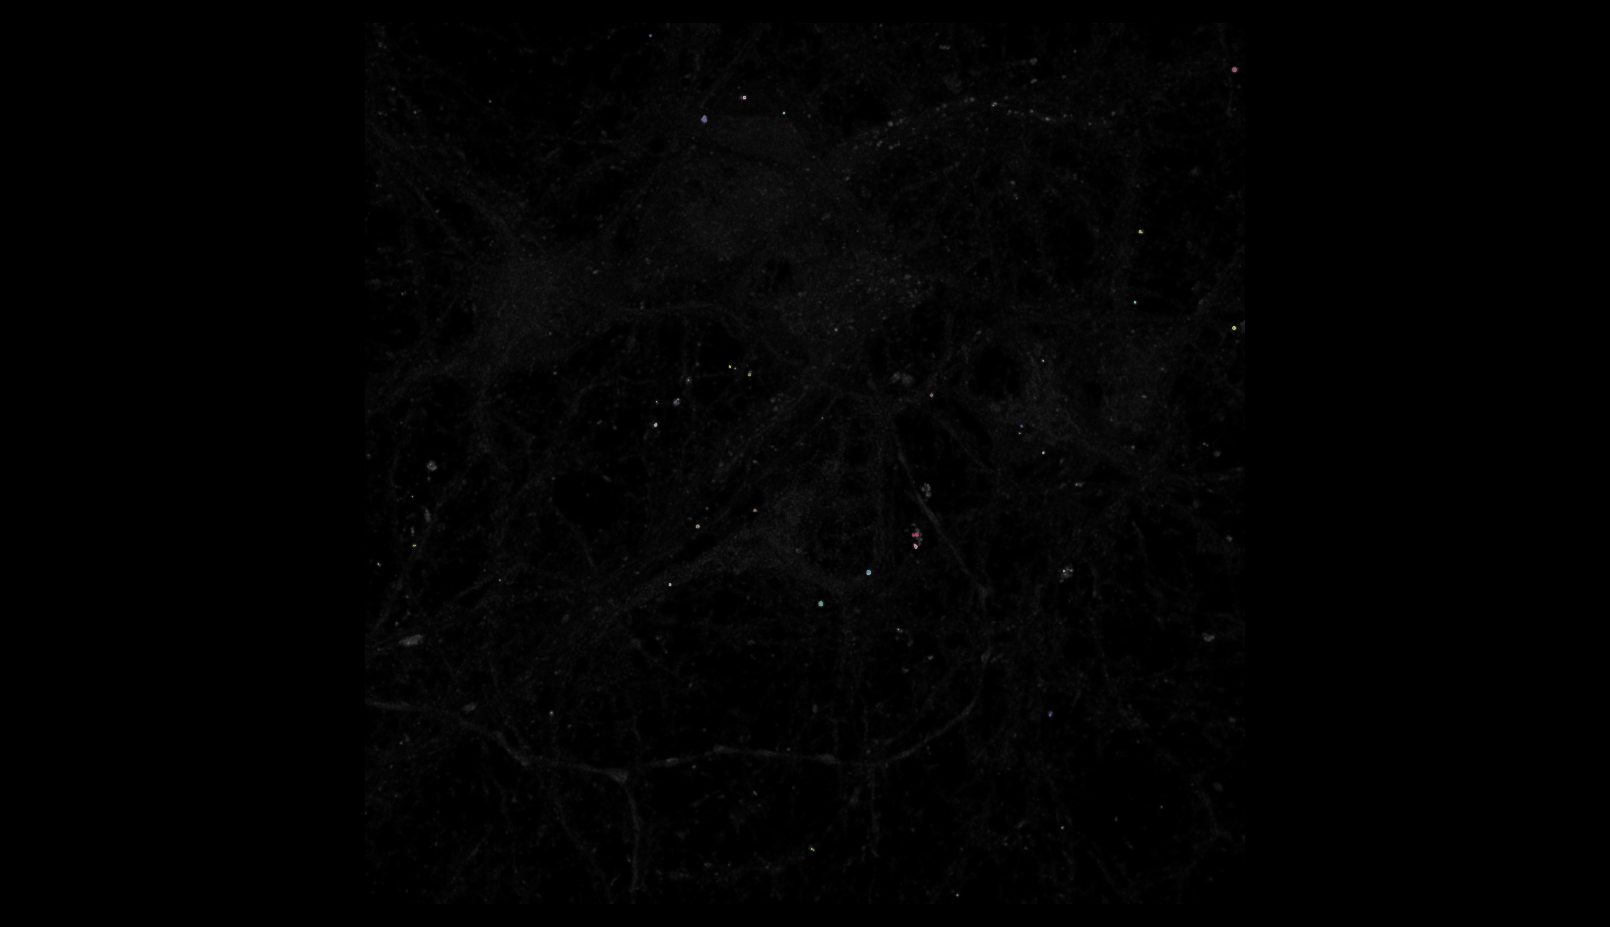

In [35]:
nbscreenshot(viewer, canvas_only=True)

In [36]:
viewer.close()

-------------  
###  **VOILÀ, All segementations are complete!!! 🎉🎉🎉**

### NEXT: Quantification

proceed to quantification folder
